# 1. Introduction
## 1.1 Background
When deciding on where to start their business or open a new branch, firms want to find a location where the new store has the highest potential to thrive. While factors such as real estate costs, local economy, and demographics profiles are important bulletin points for consideration, it is critical to understand the basics: local preferences for the business. While human preferences are subjective and cannot be directly inferred, examining how local businesses perform is a reasonable way to make the inference. For example, if there are many Italian restaurants in a certain neighborhood, that means in this area, people like Italian food. Nonetheless, this does not mean one should rush into the market and open an Italian restaurant in this specific area. The market has been filled with competitors in Italian food. In such case, a neighborhood that is similar to this “successful area” that has not yet many Italian restaurants available should be considered. Similarly, when a firm has succeeded in a local area and is contemplating opening a new branch, the firm should consider opening a new store somewhere else that is similar to the current area rather than insert one more store in the original place. In a word, it is important to understand the similarity among different neighborhoods in terms of preferences for different types of business and. I get a snapshot of local preferences for certain types of businesses by looking at the distribution of types of businesses that thrive in the local area to 

In this case study, I analyze the similarity among the neighborhoods of the three cities, Philadelphia (Center City), New York City, and Toronto through cluster analysis and computation of Euclidean distance matrix. This analysis helps firms formulate steps in pinning down areas that potentially favor the business they do. 

## 1.2 Approach
The distribution of different categories of venues is an accurate snapshot of what the neighborhood looks like and what kinds of venues thrive in the local area. Therefore, I collect information on the distribution of venue categories within a neighborhood using Foursquare API data. I run cluster analysis to capture a sense of what neighborhoods appear relatively similar. Using Word Cloud, I capture what the top venue categories are within each cluster. I measure how dissimilar the clusters are to each other using Euclidean distance across clusters. Finally, I obtain the distribution of clusters for each city, and compute the Euclidean distance among the cities based on the distribution to quantify their dissimilarity.

# 2. Data
I scrape neighborhood information of Philadelphia from Wikipedia. I use Foursquare data for the cluster analysis. Given the coordinate of a selected location, Foursquare API generates the most popular 100 venues within the radius of 2 kilometers of the location. I input the CenterPoint of each neighborhood and use the generated venues to approximate the most popular venues within that neighborhood. I define similarity between two neighborhoods as the similarity in the distribution of venue categories between the two neighborhoods. Foursquare data has category information for each venue. Using such information, I obtain the distribution of venue categories in each neighborhood by computing the frequency of occurrence of venue categories within the neighborhood. I calculate Euclidean distance among neighborhoods based on the constructed venue category distributions. Two neighborhoods are more similar if the Euclidean distance is smaller.  

# 3. Get the tables of neighborhoods of New York, Toronto, and Philadelphia and Merge them into a new dataset

In [1]:
# load packages
import pandas as pd
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)
import numpy as np

import requests
from bs4 import BeautifulSoup

import json # library to handle JSON files

# !conda install -c conda-forge geopy --yes # uncomment this line if you haven't completed the Foursquare API lab
import geopy.geocoders
from geopy.geocoders import Nominatim # convert an address into latitude and longitude values

import requests # library to handle requests
from pandas.io.json import json_normalize # tranform JSON file into a pandas dataframe

# Matplotlib and associated plotting modules
import matplotlib.cm as cm
import matplotlib.colors as colors

# import k-means from clustering stage
from sklearn.cluster import KMeans

!conda install -c conda-forge folium=0.5.0 --yes # uncomment this line if you haven't completed the Foursquare API lab
import folium # map rendering library

print('Libraries imported.')

Solving environment: done

## Package Plan ##

  environment location: /opt/conda/envs/Python36

  added / updated specs: 
    - folium=0.5.0


The following packages will be downloaded:

    package                    |            build
    ---------------------------|-----------------
    certifi-2019.9.11          |           py36_0         147 KB  conda-forge
    folium-0.5.0               |             py_0          45 KB  conda-forge
    openssl-1.1.1c             |       h516909a_0         2.1 MB  conda-forge
    ca-certificates-2019.9.11  |       hecc5488_0         144 KB  conda-forge
    branca-0.3.1               |             py_0          25 KB  conda-forge
    vincent-0.4.4              |             py_1          28 KB  conda-forge
    altair-3.2.0               |           py36_0         770 KB  conda-forge
    ------------------------------------------------------------
                                           Total:         3.3 MB

The following NEW packages will be 

In [2]:
html = requests.get("https://en.wikipedia.org/wiki/List_of_Philadelphia_neighborhoods")
b = BeautifulSoup(html.content,'lxml')
phillyList = []

In [3]:
# scrape the list of neighborhoods from wikipedia
for i in b.find_all(name = 'ul'):
    # pull the actual link for each one
    for link in i.find_all('li'):
        temp = []
        for sub_link in link.find_all('a', title=True):
            temp.append(sub_link.next_element)
        if len(temp) != 0:
            phillyList.append(temp[0])

In [4]:
# clean the list of neighborhoods
phillyList = phillyList[0:(phillyList.index('Winchester Park')+1)]

In [5]:
# get the list of boroughs
phillyBList = []
[phillyBList.append('Center City') for i in range(phillyList.index('Washington Square West')+1)] 
[phillyBList.append('South Philadelphia') for i in range(phillyList.index('Washington Square West')+1,phillyList.index('Graduate Hospital')+1)]; 
[phillyBList.append('Southwest Philadelphia') for i in range(phillyList.index('Graduate Hospital')+1,phillyList.index('Hog Island')+1)];
[phillyBList.append('West Philadelphia') for i in range(phillyList.index('Hog Island')+1,phillyList.index('Wynnefield')+1)];
[phillyBList.append('Lower North Philadelphia') for i in range(phillyList.index('Wynnefield')+1,phillyList.index('Northern Liberties')+1)]; 
[phillyBList.append('Upper North Philadelphia') for i in range(phillyList.index('Northern Liberties')+1,phillyList.index('Nicetown-Tioga')+1)]; 
[phillyBList.append('Bridesburg-Kensington-Port Richmond') for i in range(phillyList.index('Nicetown-Tioga')+1,phillyList.index('Port Richmond')+1)];
[phillyBList.append('Roxborough-Manayunk') for i in range(phillyList.index('Port Richmond')+1,phillyList.index('Manayunk')+1)];
[phillyBList.append('Germantown-Chestnut Hill') for i in range(phillyList.index('Manayunk')+1,phillyList.index('Cedarbrook')+1)];
[phillyBList.append('Olney-Oak Lane') for i in range(phillyList.index('Cedarbrook')+1,phillyList.index('Olney')+1)];
[phillyBList.append('Near Northeast Philadelphia') for i in range(phillyList.index('Olney')+1,phillyList.index('Wissinoming')+1)];
[phillyBList.append('Far Northeast Philadelphia') for i in range(phillyList.index('Wissinoming')+1,phillyList.index('Winchester Park')+1)];

In [6]:
# take a look at the data
df_PHL = pd.DataFrame({'Borough':phillyBList, 'Neighborhood':phillyList})
print("There are {} districts in Philadelphia, with a total of {} neighborhoods".format(len(df_PHL['Borough'].unique()),len(df_PHL['Neighborhood'].unique())))
df_PHL.head()

There are 12 districts in Philadelphia, with a total of 161 neighborhoods


,Borough,Neighborhood
0,Center City,Avenue of the Arts
1,Center City,Callowhill
2,Center City,Chinatown
3,Center City,Elfreth's Alley
4,Center City,French Quarter


In [7]:
# Get to know the distribution
df_PHL['Borough'].value_counts()

South Philadelphia                     29
West Philadelphia                      26
Center City                            18
Near Northeast Philadelphia            18
Far Northeast Philadelphia             16
Southwest Philadelphia                 13
Lower North Philadelphia               12
Olney-Oak Lane                          8
Germantown-Chestnut Hill                6
Upper North Philadelphia                5
Roxborough-Manayunk                     5
Bridesburg-Kensington-Port Richmond     5
Name: Borough, dtype: int64

In [8]:
# Get coordinates of the locations and visualize them
# Try with "University City"
# address = "French Quarter, Center City, Philadelphia, PA"
# geolocator = Nominatim(user_agent="philly_explorer")
# location = geolocator.geocode(address)
# latitude = location.latitude
# longitude = location.longitude
# print("The latitude of University, West Philadelphia, Philadelphia, PA is: {:.3f}".format(latitude))
# print("The longitude of University, West Philadelphia, Philadelphia, PA is: {:.3f}".format(longitude))

In [9]:
!pip install geocoder
import geocoder
# Get coordinates of the locations and visualize them
# Try with "University City"
address = "Elfreth's Alley, Center City, Philadelphia, PA"
location = geocoder.arcgis(address)
lat_lng_coords = location.latlng
latitude = lat_lng_coords[0]
longitude = lat_lng_coords[1]
print("The latitude of Elfreth's Alley, Center City, Philadelphia, PA is: {:.4f}".format(latitude))
print("The longitude of Elfreth's Alley, Center City, Philadelphia, PA is: {:.4f}".format(longitude))

     |████████████████████████████████| 102kB 15.4MB/s ta 0:00:01
The latitude of Elfreth's Alley, Center City, Philadelphia, PA is: 39.9528
The longitude of Elfreth's Alley, Center City, Philadelphia, PA is: -75.1424


In [10]:
# Get the coordinates for all neighborhoods of Philadelphia
for index, row in df_PHL.iterrows():
    address = "{}, {}, Philadelphia, PA".format(row.Neighborhood,row.Borough)
    location = None
    while (location is None):
        location = geocoder.arcgis(address)
    lat_lng_coords = location.latlng
    latitude = lat_lng_coords[0]
    longitude = lat_lng_coords[1]
    df_PHL.at[index,'Latitude'] = latitude
    df_PHL.at[index,'Longitude'] = longitude

In [11]:
# get a view of the data
df_PHL.head()
print("The number of null value: {}".format(df_PHL['Latitude'].isnull().sum()))
# add a city label
PHL_list = ['Philadelphia'] * len(df_PHL)
print("The PHL_list has %d elements" % (len(PHL_list)))
# add a column in df_PHL
df_PHL["City"] = PHL_list
df_PHL.head()
columns = [df_PHL.columns[-1]]+list(df_PHL.columns[:-1])
print(columns)
df_PHL = df_PHL[columns]
df_PHL.head()

The number of null value: 0
The PHL_list has 161 elements
['City', 'Borough', 'Neighborhood', 'Latitude', 'Longitude']


,City,Borough,Neighborhood,Latitude,Longitude
0,Philadelphia,Center City,Avenue of the Arts,39.944626,-75.165316
1,Philadelphia,Center City,Callowhill,39.958111,-75.150230
2,Philadelphia,Center City,Chinatown,39.955970,-75.158160
3,Philadelphia,Center City,Elfreth's Alley,39.952763,-75.142396
4,Philadelphia,Center City,French Quarter,39.951300,-75.154740


In [12]:
# visualize the city on the map
# Get the coordinate of Philadelphia
address = "Philadelphia, PA"
location = geocoder.arcgis(address)
lat_lng_coords = location.latlng
latitude = lat_lng_coords[0]
longitude = lat_lng_coords[1]

map_PHL = folium.Map(location=[latitude,longitude], zoom_start = 10)

for lat, lng, borough, neighbourhood in zip(df_PHL['Latitude'], df_PHL['Longitude'], df_PHL['Borough'], df_PHL['Neighborhood']):
    label = "({}), {}".format(neighbourhood, borough)
    label = folium.Popup(label, parse_html = True)
    folium.CircleMarker(
        [lat, lng],
        radius = 5,
        popup = label,
        color = 'blue',
        fill = True,
        fill_color = 'red',
        fill_opacity = 0.5,
        parse_html = True).add_to(map_PHL)
map_PHL

In [13]:
# Data from Toronto
res = requests.get("https://en.wikipedia.org/wiki/List_of_postal_codes_of_Canada:_M")
soup = BeautifulSoup(res.content,'lxml')
table = soup.find_all('table')[0]
df_Toronto = pd.read_html(str(table))[0]

df_Toronto = df_Toronto[df_Toronto['Borough'] != 'Not assigned']
df_Toronto = df_Toronto.reset_index(drop=True)
for i, row in df_Toronto.iterrows():
    if (row['Borough'] != 'Not assigned') & (row['Neighbourhood'] == 'Not assigned'):
        df_Toronto.loc[i,'Neighbourhood'] = df_Toronto.loc[i,'Borough']

df_Toronto = df_Toronto.groupby(['Postcode', 'Borough']).agg(lambda x: tuple(x)).applymap(list)
df_Toronto = df_Toronto.reset_index()
for index, row in df_Toronto.iterrows():
    elements = len(row['Neighbourhood'])
    df_Toronto.at[index,'Neighbourhood2'] = ''
    for i in range(elements):
        df_Toronto.at[index,'Neighbourhood2'] = df_Toronto.at[index,'Neighbourhood2'] + row['Neighbourhood'][i] + ', '
    df_Toronto.loc[index,'Neighbourhood2'] = df_Toronto.loc[index,'Neighbourhood2'][:-2]
df_Toronto = df_Toronto.drop('Neighbourhood',axis=1)
df_Toronto.columns = ['Postcode', 'Borough', 'Neighborhood']

for index, row in df_Toronto.iterrows():
    location = None
    while (location is None):
        location = geocoder.arcgis('{}, Toronto, Ontario'.format(row.Postcode))
    
    lat_lng_coords = location.latlng  
    df_Toronto.at[index,'Latitude'] = lat_lng_coords[0]
    df_Toronto.at[index,'Longitude'] = lat_lng_coords[1]
    
df_Toronto.head()

,Postcode,Borough,Neighborhood,Latitude,Longitude
0,M1B,Scarborough,"Rouge, Malvern",43.811525,-79.195517
1,M1C,Scarborough,"Highland Creek, Rouge Hill, Port Union",43.785730,-79.158750
2,M1E,Scarborough,"Guildwood, Morningside, West Hill",43.765690,-79.175256
3,M1G,Scarborough,Woburn,43.768359,-79.217590
4,M1H,Scarborough,Cedarbrae,43.769688,-79.239440


In [14]:
# get a view of the data
print("The number of null value: {}".format(df_Toronto['Latitude'].isnull().sum()))

# add a city label
Toronto_list = ['Toronto'] * len(df_Toronto)
print("The Toronto_list has %d elements" % (len(Toronto_list)))

# add a column in df_PHL
df_Toronto["City"] = Toronto_list
df_Toronto.head()
columns = [df_Toronto.columns[-1]]+list(df_Toronto.columns[:-1])
print(columns)
df_Toronto = df_Toronto[columns]

# drop postcode col
df_Toronto = df_Toronto.drop('Postcode', axis=1)
df_Toronto.head()

The number of null value: 0
The Toronto_list has 103 elements
['City', 'Postcode', 'Borough', 'Neighborhood', 'Latitude', 'Longitude']


,City,Borough,Neighborhood,Latitude,Longitude
0,Toronto,Scarborough,"Rouge, Malvern",43.811525,-79.195517
1,Toronto,Scarborough,"Highland Creek, Rouge Hill, Port Union",43.785730,-79.158750
2,Toronto,Scarborough,"Guildwood, Morningside, West Hill",43.765690,-79.175256
3,Toronto,Scarborough,Woburn,43.768359,-79.217590
4,Toronto,Scarborough,Cedarbrae,43.769688,-79.239440


In [15]:
df_Toronto['Borough'].value_counts().sum()

103

In [16]:
# Get location data for New York
!wget -q -O 'newyork_data.json' https://cocl.us/new_york_dataset
print('Data downloaded!')

with open('newyork_data.json') as json_data:
    newyork_data = json.load(json_data)

neighborhoods_data = newyork_data['features']    

# define the dataframe columns
column_names = ['Borough', 'Neighborhood', 'Latitude', 'Longitude'] 

# instantiate the dataframe
df_NewYork = pd.DataFrame(columns=column_names)

for data in neighborhoods_data:
    borough = data['properties']['borough'] 
    neighborhood_name = data['properties']['name']
        
    neighborhood_latlon = data['geometry']['coordinates']
    neighborhood_lat = neighborhood_latlon[1]
    neighborhood_lon = neighborhood_latlon[0]
    
    df_NewYork = df_NewYork.append({'Borough': borough,
                                          'Neighborhood': neighborhood_name,
                                          'Latitude': neighborhood_lat,
                                          'Longitude': neighborhood_lon}, ignore_index=True)

# get a view of the data
print("The number of null value: {}".format(df_NewYork['Latitude'].isnull().sum()))

# add a city label
NY_list = ['New York City'] * len(df_NewYork)
print("The NY_list has %d elements" % (len(NY_list)))

# add a column in df_PHL
df_NewYork["City"] = NY_list
df_NewYork.head()
columns = [df_NewYork.columns[-1]]+list(df_NewYork.columns[:-1])
print(columns)
df_NewYork = df_NewYork[columns]

df_NewYork.head()

Data downloaded!
The number of null value: 0
The NY_list has 306 elements
['City', 'Borough', 'Neighborhood', 'Latitude', 'Longitude']


,City,Borough,Neighborhood,Latitude,Longitude
0,New York City,Bronx,Wakefield,40.894705,-73.847201
1,New York City,Bronx,Co-op City,40.874294,-73.829939
2,New York City,Bronx,Eastchester,40.887556,-73.827806
3,New York City,Bronx,Fieldston,40.895437,-73.905643
4,New York City,Bronx,Riverdale,40.890834,-73.912585


In [17]:
df_NewYork['Borough'].value_counts().sum()

306

In [18]:
# Merge the three datasets together
df = df_PHL.append(df_Toronto).append(df_NewYork).reset_index(drop=True)
print(df.shape)
df.head()

(570, 5)


,City,Borough,Neighborhood,Latitude,Longitude
0,Philadelphia,Center City,Avenue of the Arts,39.944626,-75.165316
1,Philadelphia,Center City,Callowhill,39.958111,-75.150230
2,Philadelphia,Center City,Chinatown,39.955970,-75.158160
3,Philadelphia,Center City,Elfreth's Alley,39.952763,-75.142396
4,Philadelphia,Center City,French Quarter,39.951300,-75.154740


# 4. Get the venue information using Foursquare API

## 4.1 Define credentials and version

In [19]:
client_id = "LKKVDN4NKFTRZE3SF10TTJ1WQ4EF3HDYQXRO3B5VMKLA2YSG"
client_secret = "NEM5FKYIJLKP5EL3EKUAW5CA4DR3HELLNXEBNEBXKUV5UBAR"
version = "20180605"

## 4.2 Get Top 100 venues within 500 meter radius of the centerpoint of each neighborhood

### 4.2.1 Define the function that fetches such information using Foursquare API

In [20]:
def getNearbyVenues(city_name, borough_name, neighborhood_name, latitude, longitude, limit=1000, radius=2000):
    
    venues_list =[]
    i=0
    for nn, bn, cn, lat, lng in zip(neighborhood_name, borough_name, city_name, latitude, longitude):
        print(i, nn,bn,cn)
        
        # create API request url
        url = "https://api.foursquare.com/v2/venues/explore?client_id={}&client_secret={}&v={}&ll={},{}&limit={}&radius={}".format(
        client_id,
        client_secret,
        version,
        lat,
        lng,
        limit,
        radius)
        
        # make the GET request
        results = requests.get(url).json()['response']['groups'][0]['items']
        
        venues_list.append([(cn,
                             bn,
                             nn,
                             lat,
                             lng,
                             result['venue']['name'],
                             result['venue']['location']['lat'],
                             result['venue']['location']['lng'],
                             result['venue']['categories'][0]['name']) for result in results])
        i+=1
        
    nearby_venues = pd.DataFrame([item for venue_list in venues_list for item in venue_list])
    nearby_venues.columns = [
        'City',
        'Borough',
        'Neighborhood',
        'Latitude',
        'Longitude',
        'Venue',
        'Venue Latitude',
        'Venue Longtidue',
        'Venue Category'
    ]
    
    return(nearby_venues)

## 4.2 Run the function to fetch nearby top venues

In [21]:
venues_list = getNearbyVenues(df['City'],df['Borough'],df['Neighborhood'],df['Latitude'], df['Longitude'])

0 Avenue of the Arts Center City Philadelphia
1 Callowhill Center City Philadelphia
2 Chinatown Center City Philadelphia
3 Elfreth's Alley Center City Philadelphia
4 French Quarter Center City Philadelphia
5 Logan Square Center City Philadelphia
6 Naval Square Center City Philadelphia
7 Jewelers' Row Center City Philadelphia
8 Market East Center City Philadelphia
9 Old City Center City Philadelphia
10 Museum District Center City Philadelphia
11 Penn Center Center City Philadelphia
12 Rittenhouse Square Center City Philadelphia
13 Fitler Square Center City Philadelphia
14 Penn's Landing Center City Philadelphia
15 Society Hill Center City Philadelphia
16 South Street Center City Philadelphia
17 Washington Square West Center City Philadelphia
18 Bella Vista South Philadelphia Philadelphia
19 Central South Philadelphia South Philadelphia Philadelphia
20 Devil's Pocket South Philadelphia Philadelphia
21 Dickinson Square West South Philadelphia Philadelphia
22 East Passyunk Crossing South P

In [22]:
venues_list.head()

,City,Borough,Neighborhood,Latitude,Longitude,Venue,Venue Latitude,Venue Longtidue,Venue Category
0,Philadelphia,Center City,Avenue of the Arts,39.944626,-75.165316,Kimmel Center for the Performing Arts,39.946785,-75.165234,Concert Hall
1,Philadelphia,Center City,Avenue of the Arts,39.944626,-75.165316,PHS Pop-Up Beer Garden,39.943662,-75.166950,Beer Garden
2,Philadelphia,Center City,Avenue of the Arts,39.944626,-75.165316,Writer's Block Rehab,39.946450,-75.163602,Cocktail Bar
3,Philadelphia,Center City,Avenue of the Arts,39.944626,-75.165316,REX 1516,39.943977,-75.167725,Southern / Soul Food Restaurant
4,Philadelphia,Center City,Avenue of the Arts,39.944626,-75.165316,Verizon Hall,39.946598,-75.165976,Concert Hall


In [32]:
# url = "https://api.foursquare.com/v2/venues/explore?client_id={}&client_secret={}&v={}&ll={},{}&limit={}&radius={}".format(
#        client_id,
#        client_secret,
#        version,
#        39.903560,
#        -75.159290,
#        100,
#        500)
# results = requests.get(url).json()['response']['groups'][0]['items']

In [23]:
venues_list.shape

(50865, 9)

In [24]:
venues_list.groupby(['City']).count()

,Borough,Neighborhood,Latitude,Longitude,Venue,Venue Latitude,Venue Longtidue,Venue Category
City,,,,,,,,
New York City,28281,28281,28281,28281,28281,28281,28281,28281
Philadelphia,14148,14148,14148,14148,14148,14148,14148,14148
Toronto,8436,8436,8436,8436,8436,8436,8436,8436


## 4.3 Check how many unique categories can be curated from all the returned venues

In [25]:
print("There are {} unique categories.".format(len(venues_list['Venue Category'].unique())))

There are 502 unique categories.


In [26]:
venues_list.groupby(['City','Borough','Neighborhood']).count().shape

(570, 6)

## 4.4 Create waffle charts and word clouds to understand the distribution of categories of each city.

### 4.4.1 Transform the "Venue Category"variable into dummy variables indicating categories

In [27]:
df_onehot = pd.get_dummies(venues_list['Venue Category'])
df_onehot[['City','Borough','Neighbourhood']] = venues_list[['City','Borough','Neighborhood']]
column_names = list(df_onehot.columns[-3:])+list(df_onehot.columns[:-3])
df_onehot = df_onehot[column_names]
df_onehot.columns = column_names
df_onehot.head()

,City,Borough,Neighbourhood,ATM,Accessories Store,Adult Boutique,Afghan Restaurant,African Restaurant,Airport,Airport Lounge,Airport Service,Airport Terminal,American Restaurant,Amphitheater,Animal Shelter,Antique Shop,Aquarium,Arcade,Arepa Restaurant,Argentinian Restaurant,Art Gallery,Art Museum,Arts & Crafts Store,Arts & Entertainment,Asian Restaurant,Athletics & Sports,Auditorium,Australian Restaurant,Austrian Restaurant,Auto Dealership,Auto Garage,Auto Workshop,Automotive Shop,BBQ Joint,Baby Store,Badminton Court,Bagel Shop,Bakery,Bank,Bar,Baseball Field,Baseball Stadium,Basketball Court,Basketball Stadium,Bath House,Beach,Beach Bar,Bed & Breakfast,Beer Bar,Beer Garden,Beer Store,Big Box Store,Bike Rental / Bike Share,Bike Shop,Bike Trail,Bistro,Board Shop,Boarding House,Boat or Ferry,Bookstore,Border Crossing,Botanical Garden,Boutique,Bowling Alley,Boxing Gym,Brazilian Restaurant,Breakfast Spot,Brewery,Bridal Shop,Bridge,Bubble Tea Shop,Buffet,Building,Burger Joint,Burmese Restaurant,Burrito Place,Bus Line,Bus Station,Bus Stop,Business Center,Business Service,Butcher,Cafeteria,Café,Cajun / Creole Restaurant,Cambodian Restaurant,Camera Store,Campground,Candy Store,Cantonese Restaurant,Car Wash,Caribbean Restaurant,Castle,Caucasian Restaurant,Cemetery,Cheese Shop,Chinese Restaurant,Chiropractor,Chocolate Shop,Church,Churrascaria,City Hall,Climbing Gym,Clothing Store,Club House,Cocktail Bar,Coffee Shop,College Academic Building,College Arts Building,College Basketball Court,College Bookstore,College Gym,College Quad,College Rec Center,Colombian Restaurant,Comedy Club,Comfort Food Restaurant,Comic Shop,Community Center,Concert Hall,Construction & Landscaping,Convenience Store,Convention Center,Cooking School,Cosmetics Shop,Costume Shop,Coworking Space,Creperie,Cuban Restaurant,Cultural Center,Cupcake Shop,Curling Ice,Cycle Studio,Czech Restaurant,Dance Studio,Daycare,Deli / Bodega,Department Store,Design Studio,Dessert Shop,Dim Sum Restaurant,Diner,Disc Golf,Discount Store,Distillery,Dive Bar,Doctor's Office,Dog Run,Doner Restaurant,Donut Shop,Dosa Place,Drugstore,Dry Cleaner,Dumpling Restaurant,Dutch Restaurant,Eastern European Restaurant,Egyptian Restaurant,Electronics Store,Elementary School,Empanada Restaurant,English Restaurant,Entertainment Service,Ethiopian Restaurant,Event Service,Event Space,Exhibit,Eye Doctor,Fabric Shop,Factory,Falafel Restaurant,Farm,Farmers Market,Fast Food Restaurant,Field,Filipino Restaurant,Film Studio,Financial or Legal Service,Fish & Chips Shop,Fish Market,Fishing Store,Flea Market,Flower Shop,Food,Food & Drink Shop,Food Court,Food Stand,Food Truck,Football Stadium,Fountain,French Restaurant,Fried Chicken Joint,Frozen Yogurt Shop,Fruit & Vegetable Store,Furniture / Home Store,Gaming Cafe,Garden,Garden Center,Gas Station,Gastropub,Gay Bar,General Entertainment,German Restaurant,Gift Shop,Gluten-free Restaurant,Go Kart Track,Golf Course,Gourmet Shop,Government Building,Greek Restaurant,Grocery Store,Gun Range,Gym,Gym / Fitness Center,Gym Pool,Gymnastics Gym,Hakka Restaurant,Halal Restaurant,Harbor / Marina,Hardware Store,Hawaiian Restaurant,Health & Beauty Service,Health Food Store,Heliport,Herbs & Spices Store,High School,Himalayan Restaurant,Historic Site,History Museum,Hobby Shop,Hockey Arena,Hockey Field,Home Service,Hong Kong Restaurant,Hookah Bar,Hospital,Hostel,Hot Dog Joint,Hotel,Hotel Bar,Hotpot Restaurant,Housing Development,Hungarian Restaurant,IT Services,Ice Cream Shop,Indian Chinese Restaurant,Indian Restaurant,Indie Movie Theater,Indie Theater,Indonesian Restaurant,Indoor Play Area,Insurance Office,Intersection,Irish Pub,Island,Israeli Restaurant,Italian Restaurant,Japanese Restaurant,Jazz Club,Jewelry Store,Jewish Restaurant,Juice Bar,Karaoke Bar,Kebab Restaurant,Kids Store,Kitchen Supply Store,Kofte Place,Korean Restaurant,Kosher Restaurant,Lake,Laser Tag,Latin American Restaurant,Laundromat,Laundry Service,Lawyer,Leather Goods Store,Lebanese Restaurant,Library,Light Rail Stat

### 4.4.2 Compute the total counts of popular venues by category for each city

In [28]:
df_sum_by_city = df_onehot.groupby('City').sum()
df_sum_by_city['Total'] = df_sum_by_city.sum(axis=1)
df_sum_by_city['Num of Neighbourhoods'] = df_onehot[['City','Neighbourhood']].groupby('City').nunique()['Neighbourhood']
df_sum_by_city['Average Venues'] = df_sum_by_city['Total']/df_sum_by_city['Num of Neighbourhoods']
df_sum = pd.DataFrame(df_sum_by_city.sum(axis=0)).T
df_sum.index.name = 'City'
df_sum.index = ['Overall']
df_sum_by_city = df_sum_by_city.append(df_sum)

### 4.4.3 Create waffle chart that shows top 5 categories of each city

#### 4.4.3.1 Create a function that plots waffle chart

In [29]:
def create_waffle_chart(categories, values, height, width, colormap, value_sign=''):
    
    # compute the proportion of each category with respect to the total
    total_values = sum(values)
    category_proportions = [(float(value) / total_values) for value in values]
    
    # compute the total number of tiles
    total_num_tiles = width * height # total number of tiles
    print ('Total number of tiles is', total_num_tiles)
    
    # compute the number of tiles for each catagory
    tiles_per_category = [round(proportion * total_num_tiles) for proportion in category_proportions]
    
    # print out number of tiles per category
    for i, tiles in enumerate(tiles_per_category):
        print (categories[i] + ': ' + str(tiles))
        
    # initialize the waffle chart as an empty matrix
    waffle_chart = np.zeros((height, width))
    
    # define indices to loop through waffle chart
    category_index = 0
    tile_index = 0
    
    # populate the waffle chart
    for col in range(width):
        for row in range(height):
            tile_index += 1

            # if the number of tiles populated for the current category 
            # is equal to its corresponding allocated tiles...
            if tile_index > sum(tiles_per_category[0:category_index]):
                # ...proceed to the next category
                category_index += 1       
            
            # set the class value to an integer, which increases with class
            waffle_chart[row, col] = category_index
            
    # instantiate a new figure object
    fig = plt.figure()

    # use matshow to display the waffle chart
    colormap = plt.cm.coolwarm
    plt.matshow(waffle_chart, cmap=colormap)
    # plt.colorbar()

    # get the axis
    ax = plt.gca()

    # set minor ticks
    ax.set_xticks(np.arange(-.5, (width), 1), minor=True)
    ax.set_yticks(np.arange(-.5, (height), 1), minor=True)
    
    # add dridlines based on minor ticks
    ax.grid(which='minor', color='w', linestyle='-', linewidth=2)

    plt.xticks([])
    plt.yticks([])
    
    # compute cumulative sum of individual categories to match color schemes between chart and legend
    values_cumsum = np.cumsum(values)
    total_values = values_cumsum[len(values_cumsum) - 1]
    
    # create legend
    legend_handles = []
    for i, category in enumerate(categories):
        if value_sign == '%':
            label_str = category + ' (' + str(round(values[i]/total_values*100).astype('int32')) + value_sign + ')'
        else:
            label_str = category + ' (' + value_sign + str(values[i]) + ')'
            
        # color_val = colormap(float(values_cumsum[i])/total_values)
        color_val = colormap((i+0.7)/len(values_cumsum))
        legend_handles.append(mpatches.Patch(color=color_val, label=label_str))
        
    # add legend to chart
    plt.legend(
        handles=legend_handles,
        loc='lower center', 
        ncol=len(categories),
        bbox_to_anchor=(0., -0.2, 0.95, .1)

    )

#### 4.4.3.2 Load package for plotting

In [30]:
import numpy as np  # useful for many scientific computing in Python
import pandas as pd # primary data structure library
from PIL import Image # converting images into arrays

%matplotlib inline

import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches # needed for waffle Charts

mpl.style.use('ggplot') # optional: for ggplot-like style

# check for latest version of Matplotlib
print ('Matplotlib version: ', mpl.__version__) # >= 2.0.0

Matplotlib version:  3.0.2


#### 4.4.3.2 Apply the function on New York City, Philadelphia, Toronto, and Overall

Total number of tiles is 400
Pizza Place: 121
Coffee Shop: 87
Italian Restaurant: 71
Park: 64
Sandwich Place: 58


Text(0.5, 1.05, 'Overall')

<Figure size 432x288 with 0 Axes>

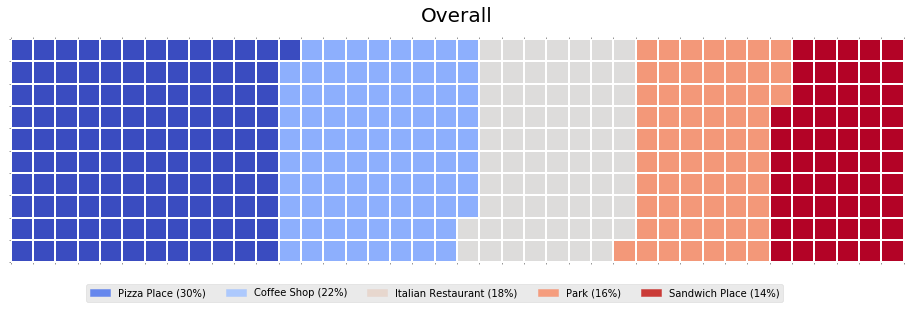

In [31]:
city_venues = df_sum_by_city.iloc[3,:-3]
city_venues_sorted = city_venues.sort_values(ascending=False).head(5)
categories =  city_venues_sorted.index.values
values = city_venues_sorted
height = 10
width = 40
colormap = plt.cm.coolwarm
value_sign='%'
create_waffle_chart(categories, values, height, width, colormap, value_sign)
plt.title('Overall',fontsize=20)

### 4.4.4 Frequency of Categories across neighborhoods

#### 4.4.4.1 Calculate the frequency of occurrence of each category within each neighbourhood

In [32]:
df_freq_by_neighbourhood = df_onehot.groupby(['City','Borough','Neighbourhood']).mean()
df_freq_top2 = df_freq_by_neighbourhood[['Park','Sandwich Place']]
df_freq_top2

Park  \
City          Borough                             Neighbourhood                                                  
New York City Bronx                               Allerton                                            0.030000   
                                                  Baychester                                          0.000000   
                                                  Bedford Park                                        0.050000   
                                                  Belmont                                             0.010000   
                                                  Bronxdale                                           0.040000   
                                                  Castle Hill                                         0.051948   
                                                  City Island                                         0.055556   
                                                  Claremont Village                                   0.050000   
                                                  Clason Point                                        0.148936   
                                                  Co-op City                                          0.010000   
                                                  Concourse                                           0.070000   
                                                  Concourse Village                                   0.060000   
                                                  Country Club                                        0.030000   
                                                  East Tremont                                        0.060000   
                                                  Eastchester                                         0.000000   
                                                  Edenwald                                            0.010000   
                                                  Edgewater Park                                      0.013333   
                                                  Fieldston                                           0.040000   
                                                  Fordham                                             0.020000   
                                                  High  Bridge                                        0.060000   
                                                  Hunts Point                                         0.073171   
                                                  Kingsbridge                                         0.060000   
                                                  Kingsbridge Heights                                 0.050000   
                                                  Longwood                                            0.050000   
                                                  Melrose                                             0.040000   
                                                  Morris Heights                                      0.070000   
                                                  Morris Park                                         0.010000   
                                                  Morrisania                                          0.060000   
                                                  Mott Haven                                          0.021739   
                                                  Mount Eden                                          0.060000   
                                                  Mount Hope                                          0.020000   
                                                  North Riverdale                                     0.000000   
                                                  Norwood                                             0.060000   
                                                  Olinville                                           0.050000   
  

#### 4.4.4.2 Scatterplot of the neighborhoods

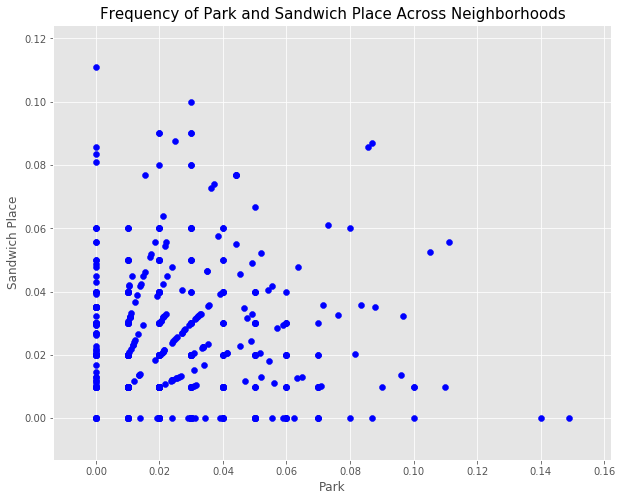

In [33]:
plt.figure(figsize=(10,8))
plt.scatter(df_freq_top2['Park'],df_freq_top2['Sandwich Place'], c='blue')
plt.xlabel('Park')
plt.ylabel('Sandwich Place')
plt.title('Frequency of Park and Sandwich Place Across Neighborhoods',fontsize=15)
plt.show()

# 5. Analyze the neighborhoods

# 5.1 Generate the Top 10 venue categories for each neighborhood

### 5.3.1 For each neighborhood, print out the top 5 venues for an overview

#### 5.3.1.1 Turn the index into columns (City, Borough, Neighbourhood)

In [34]:
df_freq_by_neighbourhood = df_freq_by_neighbourhood.reset_index()
num_top_venues = 5
df_freq_by_neighbourhood.head()

,City,Borough,Neighbourhood,ATM,Accessories Store,Adult Boutique,Afghan Restaurant,African Restaurant,Airport,Airport Lounge,Airport Service,Airport Terminal,American Restaurant,Amphitheater,Animal Shelter,Antique Shop,Aquarium,Arcade,Arepa Restaurant,Argentinian Restaurant,Art Gallery,Art Museum,Arts & Crafts Store,Arts & Entertainment,Asian Restaurant,Athletics & Sports,Auditorium,Australian Restaurant,Austrian Restaurant,Auto Dealership,Auto Garage,Auto Workshop,Automotive Shop,BBQ Joint,Baby Store,Badminton Court,Bagel Shop,Bakery,Bank,Bar,Baseball Field,Baseball Stadium,Basketball Court,Basketball Stadium,Bath House,Beach,Beach Bar,Bed & Breakfast,Beer Bar,Beer Garden,Beer Store,Big Box Store,Bike Rental / Bike Share,Bike Shop,Bike Trail,Bistro,Board Shop,Boarding House,Boat or Ferry,Bookstore,Border Crossing,Botanical Garden,Boutique,Bowling Alley,Boxing Gym,Brazilian Restaurant,Breakfast Spot,Brewery,Bridal Shop,Bridge,Bubble Tea Shop,Buffet,Building,Burger Joint,Burmese Restaurant,Burrito Place,Bus Line,Bus Station,Bus Stop,Business Center,Business Service,Butcher,Cafeteria,Café,Cajun / Creole Restaurant,Cambodian Restaurant,Camera Store,Campground,Candy Store,Cantonese Restaurant,Car Wash,Caribbean Restaurant,Castle,Caucasian Restaurant,Cemetery,Cheese Shop,Chinese Restaurant,Chiropractor,Chocolate Shop,Church,Churrascaria,City Hall,Climbing Gym,Clothing Store,Club House,Cocktail Bar,Coffee Shop,College Academic Building,College Arts Building,College Basketball Court,College Bookstore,College Gym,College Quad,College Rec Center,Colombian Restaurant,Comedy Club,Comfort Food Restaurant,Comic Shop,Community Center,Concert Hall,Construction & Landscaping,Convenience Store,Convention Center,Cooking School,Cosmetics Shop,Costume Shop,Coworking Space,Creperie,Cuban Restaurant,Cultural Center,Cupcake Shop,Curling Ice,Cycle Studio,Czech Restaurant,Dance Studio,Daycare,Deli / Bodega,Department Store,Design Studio,Dessert Shop,Dim Sum Restaurant,Diner,Disc Golf,Discount Store,Distillery,Dive Bar,Doctor's Office,Dog Run,Doner Restaurant,Donut Shop,Dosa Place,Drugstore,Dry Cleaner,Dumpling Restaurant,Dutch Restaurant,Eastern European Restaurant,Egyptian Restaurant,Electronics Store,Elementary School,Empanada Restaurant,English Restaurant,Entertainment Service,Ethiopian Restaurant,Event Service,Event Space,Exhibit,Eye Doctor,Fabric Shop,Factory,Falafel Restaurant,Farm,Farmers Market,Fast Food Restaurant,Field,Filipino Restaurant,Film Studio,Financial or Legal Service,Fish & Chips Shop,Fish Market,Fishing Store,Flea Market,Flower Shop,Food,Food & Drink Shop,Food Court,Food Stand,Food Truck,Football Stadium,Fountain,French Restaurant,Fried Chicken Joint,Frozen Yogurt Shop,Fruit & Vegetable Store,Furniture / Home Store,Gaming Cafe,Garden,Garden Center,Gas Station,Gastropub,Gay Bar,General Entertainment,German Restaurant,Gift Shop,Gluten-free Restaurant,Go Kart Track,Golf Course,Gourmet Shop,Government Building,Greek Restaurant,Grocery Store,Gun Range,Gym,Gym / Fitness Center,Gym Pool,Gymnastics Gym,Hakka Restaurant,Halal Restaurant,Harbor / Marina,Hardware Store,Hawaiian Restaurant,Health & Beauty Service,Health Food Store,Heliport,Herbs & Spices Store,High School,Himalayan Restaurant,Historic Site,History Museum,Hobby Shop,Hockey Arena,Hockey Field,Home Service,Hong Kong Restaurant,Hookah Bar,Hospital,Hostel,Hot Dog Joint,Hotel,Hotel Bar,Hotpot Restaurant,Housing Development,Hungarian Restaurant,IT Services,Ice Cream Shop,Indian Chinese Restaurant,Indian Restaurant,Indie Movie Theater,Indie Theater,Indonesian Restaurant,Indoor Play Area,Insurance Office,Intersection,Irish Pub,Island,Israeli Restaurant,Italian Restaurant,Japanese Restaurant,Jazz Club,Jewelry Store,Jewish Restaurant,Juice Bar,Karaoke Bar,Kebab Restaurant,Kids Store,Kitchen Supply Store,Kofte Place,Korean Restaurant,Kosher Restaurant,Lake,Laser Tag,Latin American Restaurant,Laundromat,Laundry Service,Lawyer,Leather Goods Store,Lebanese Restaurant,Library,Light Rail Stat

#### 5.3.1.2 For each neighbourhood, show Top 5 categories

In [35]:
for cn, bn, nn in zip(df_freq_by_neighbourhood['City'], df_freq_by_neighbourhood['Borough'], df_freq_by_neighbourhood['Neighbourhood']):
    print("----{}----".format(cn))
    print("----{}----".format(bn))
    print("----{}----".format(nn))
    temp = df_freq_by_neighbourhood[(df_freq_by_neighbourhood.City == cn) & (df_freq_by_neighbourhood.Borough == bn) & (df_freq_by_neighbourhood.Neighbourhood == nn)].T.reset_index()
    temp.columns = ['Category','Freq']
    temp = temp.iloc[3:]
    temp = temp.sort_values(by='Freq', ascending=False).reset_index(drop=True)
    print(temp.head())

----New York City----
----Bronx----
----Allerton----
               Category  Freq
0           Pizza Place  0.11
1                Garden  0.07
2            Donut Shop  0.06
3  Caribbean Restaurant  0.05
4    Italian Restaurant  0.04
----New York City----
----Bronx----
----Baychester----
           Category  Freq
0       Pizza Place  0.07
1            Bakery  0.05
2        Donut Shop  0.05
3          Pharmacy  0.04
4  Department Store  0.04
----New York City----
----Bronx----
----Bedford Park----
             Category  Freq
0         Pizza Place  0.11
1  Italian Restaurant  0.09
2              Garden  0.07
3       Deli / Bodega  0.06
4               Diner  0.06
----New York City----
----Bronx----
----Belmont----
             Category  Freq
0  Italian Restaurant  0.14
1         Pizza Place  0.09
2                 Zoo  0.07
3              Garden  0.07
4              Bakery  0.05
----New York City----
----Bronx----
----Bronxdale----
             Category  Freq
0         Pizza Place   0.1
1

### 5.3.2 Add top 10 venues for each neighborhood to the dataframe

#### 5.3.2.1 Write a function that returns the most common venues for each row (neighborhood)

In [36]:
def return_most_common_venues(row, num_top_venues):
    row_categories = row[3:]
    row_categories_sorted = row_categories.sort_values(ascending=False)
    return row_categories_sorted.index.values[0:num_top_venues]

#### 5.3.2.2 Add top venues to the dataframe

In [37]:
num_top_venues = 10
indicators = ['st', 'nd', 'rd']

columns = ['City', 'Borough', 'Neighbourhood']
for ind in np.arange(num_top_venues):
    try:
        columns.append(str(ind+1) + indicators[ind] + ' Most Common Category')
    except:
        columns.append(str(ind+1) + 'th' + ' Most Common Category')

df_top_venues = pd.DataFrame(columns=columns)
df_top_venues[['City', 'Borough', 'Neighbourhood']] = df_freq_by_neighbourhood[['City', 'Borough', 'Neighbourhood']]

for ind in np.arange(df_top_venues.shape[0]):
    df_top_venues.iloc[ind,3:] = return_most_common_venues(df_freq_by_neighbourhood.iloc[ind],num_top_venues)

In [38]:
df_top_venues.head()

,City,Borough,Neighbourhood,1st Most Common Category,2nd Most Common Category,3rd Most Common Category,4th Most Common Category,5th Most Common Category,6th Most Common Category,7th Most Common Category,8th Most Common Category,9th Most Common Category,10th Most Common Category
0,New York City,Bronx,Allerton,Pizza Place,Garden,Donut Shop,Caribbean Restaurant,Italian Restaurant,Chinese Restaurant,Park,Trail,Liquor Store,Botanical Garden
1,New York City,Bronx,Baychester,Pizza Place,Bakery,Donut Shop,Pharmacy,Department Store,Italian Restaurant,Supermarket,Clothing Store,Caribbean Restaurant,Shopping Mall
2,New York City,Bronx,Bedford Park,Pizza Place,Italian Restaurant,Garden,Diner,Deli / Bodega,Park,Bakery,Coffee Shop,Bar,Mexican Restaurant
3,New York City,Bronx,Belmont,Italian Restaurant,Pizza Place,Zoo,Garden,Deli / Bodega,Bakery,Café,Zoo Exhibit,Dessert Shop,Latin American Restaurant
4,New York City,Bronx,Bronxdale,Pizza Place,Zoo,Zoo Exhibit,Garden,Italian Restaurant,Coffee Shop,Deli / Bodega,Donut Shop,Park,Mexican Restaurant


#### 5.3.2.2 Join the dataframe with the frequency table

In [39]:
df_complete = df_top_venues.join(df_freq_by_neighbourhood.set_index(['City', 'Borough', 'Neighbourhood']), on =['City', 'Borough', 'Neighbourhood'])
df_complete.head()

,City,Borough,Neighbourhood,1st Most Common Category,2nd Most Common Category,3rd Most Common Category,4th Most Common Category,5th Most Common Category,6th Most Common Category,7th Most Common Category,8th Most Common Category,9th Most Common Category,10th Most Common Category,ATM,Accessories Store,Adult Boutique,Afghan Restaurant,African Restaurant,Airport,Airport Lounge,Airport Service,Airport Terminal,American Restaurant,Amphitheater,Animal Shelter,Antique Shop,Aquarium,Arcade,Arepa Restaurant,Argentinian Restaurant,Art Gallery,Art Museum,Arts & Crafts Store,Arts & Entertainment,Asian Restaurant,Athletics & Sports,Auditorium,Australian Restaurant,Austrian Restaurant,Auto Dealership,Auto Garage,Auto Workshop,Automotive Shop,BBQ Joint,Baby Store,Badminton Court,Bagel Shop,Bakery,Bank,Bar,Baseball Field,Baseball Stadium,Basketball Court,Basketball Stadium,Bath House,Beach,Beach Bar,Bed & Breakfast,Beer Bar,Beer Garden,Beer Store,Big Box Store,Bike Rental / Bike Share,Bike Shop,Bike Trail,Bistro,Board Shop,Boarding House,Boat or Ferry,Bookstore,Border Crossing,Botanical Garden,Boutique,Bowling Alley,Boxing Gym,Brazilian Restaurant,Breakfast Spot,Brewery,Bridal Shop,Bridge,Bubble Tea Shop,Buffet,Building,Burger Joint,Burmese Restaurant,Burrito Place,Bus Line,Bus Station,Bus Stop,Business Center,Business Service,Butcher,Cafeteria,Café,Cajun / Creole Restaurant,Cambodian Restaurant,Camera Store,Campground,Candy Store,Cantonese Restaurant,Car Wash,Caribbean Restaurant,Castle,Caucasian Restaurant,Cemetery,Cheese Shop,Chinese Restaurant,Chiropractor,Chocolate Shop,Church,Churrascaria,City Hall,Climbing Gym,Clothing Store,Club House,Cocktail Bar,Coffee Shop,College Academic Building,College Arts Building,College Basketball Court,College Bookstore,College Gym,College Quad,College Rec Center,Colombian Restaurant,Comedy Club,Comfort Food Restaurant,Comic Shop,Community Center,Concert Hall,Construction & Landscaping,Convenience Store,Convention Center,Cooking School,Cosmetics Shop,Costume Shop,Coworking Space,Creperie,Cuban Restaurant,Cultural Center,Cupcake Shop,Curling Ice,Cycle Studio,Czech Restaurant,Dance Studio,Daycare,Deli / Bodega,Department Store,Design Studio,Dessert Shop,Dim Sum Restaurant,Diner,Disc Golf,Discount Store,Distillery,Dive Bar,Doctor's Office,Dog Run,Doner Restaurant,Donut Shop,Dosa Place,Drugstore,Dry Cleaner,Dumpling Restaurant,Dutch Restaurant,Eastern European Restaurant,Egyptian Restaurant,Electronics Store,Elementary School,Empanada Restaurant,English Restaurant,Entertainment Service,Ethiopian Restaurant,Event Service,Event Space,Exhibit,Eye Doctor,Fabric Shop,Factory,Falafel Restaurant,Farm,Farmers Market,Fast Food Restaurant,Field,Filipino Restaurant,Film Studio,Financial or Legal Service,Fish & Chips Shop,Fish Market,Fishing Store,Flea Market,Flower Shop,Food,Food & Drink Shop,Food Court,Food Stand,Food Truck,Football Stadium,Fountain,French Restaurant,Fried Chicken Joint,Frozen Yogurt Shop,Fruit & Vegetable Store,Furniture / Home Store,Gaming Cafe,Garden,Garden Center,Gas Station,Gastropub,Gay Bar,General Entertainment,German Restaurant,Gift Shop,Gluten-free Restaurant,Go Kart Track,Golf Course,Gourmet Shop,Government Building,Greek Restaurant,Grocery Store,Gun Range,Gym,Gym / Fitness Center,Gym Pool,Gymnastics Gym,Hakka Restaurant,Halal Restaurant,Harbor / Marina,Hardware Store,Hawaiian Restaurant,Health & Beauty Service,Health Food Store,Heliport,Herbs & Spices Store,High School,Himalayan Restaurant,Historic Site,History Museum,Hobby Shop,Hockey Arena,Hockey Field,Home Service,Hong Kong Restaurant,Hookah Bar,Hospital,Hostel,Hot Dog Joint,Hotel,Hotel Bar,Hotpot Restaurant,Housing Development,Hungarian Restaurant,IT Services,Ice Cream Shop,Indian Chinese Restaurant,Indian Restaurant,Indie Movie Theater,Indie Theater,Indonesian Restaurant,Indoor Play Area,Insurance Office,Intersection,Irish Pub,Island,Israeli Restaurant,Italian Restaurant,Japanese Restaurant,Jazz Club,Jewelry Store,Jewish Restaurant,Juice 

### 5.3.3 Cluster the neighborhoods

#### 5.3.3.1 Using KNN methods

##### 5.3.3.1.1 Deterine optimal k using elbow methods

In [ ]:
# try standardized X
from sklearn.preprocessing import StandardScaler
# X = df_freq_by_neighbourhood.iloc[:,3:].values
# X_standardized = StandardScaler().fit(X).transform(X)
from sklearn import metrics
from scipy.spatial.distance import cdist
distortions = []
X = df_freq_by_neighbourhood.iloc[:,3:].values
X_standardized = StandardScaler().fit(X).transform(X)
K = range(1,20)
for k in K:
    kmeans = KMeans(n_clusters=k, n_init=12, random_state=0).fit(X_standardized)
    distortions.append(sum(np.min(cdist(X_standardized, kmeans.cluster_centers_, 'euclidean'), axis=1)) / X.shape[0])
    print('iterations: {}'.format(kmeans.n_iter_))
    print('{} completed'.format(k))
# Plot the elbow
plt.plot(K, distortions, 'bx-')X
plt.xlabel('k')
plt.ylabel('Distortion')
plt.title('The Elbow Method showing the optimal k')
plt.show()

iterations: 2
1 completed
iterations: 7
2 completed
iterations: 11
3 completed
iterations: 14
4 completed
iterations: 8
5 completed
iterations: 18
6 completed
iterations: 7
7 completed
iterations: 9
8 completed
iterations: 20
9 completed
iterations: 6
10 completed
iterations: 18
11 completed
iterations: 8
12 completed
iterations: 10
13 completed


iterations: 2
1 completed
iterations: 13
2 completed
iterations: 7
3 completed
iterations: 17
4 completed
iterations: 15
5 completed
iterations: 13
6 completed
iterations: 13
7 completed
iterations: 22
8 completed
iterations: 17
9 completed
iterations: 19
10 completed
iterations: 12
11 completed
iterations: 11
12 completed
iterations: 14
13 completed
iterations: 13
14 completed
iterations: 23
15 completed
iterations: 11
16 completed
iterations: 31
17 completed
iterations: 9
18 completed
iterations: 11
19 completed


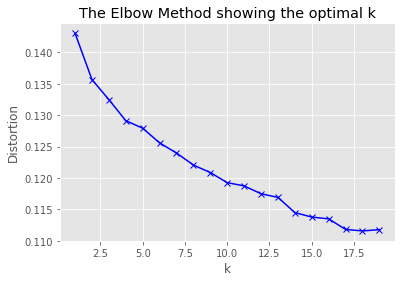

In [47]:
# go with raw data
# try with 20 
from sklearn.preprocessing import StandardScaler
# X = df_freq_by_neighbourhood.iloc[:,3:].values
# X_standardized = StandardScaler().fit(X).transform(X)
from sklearn import metrics
from scipy.spatial.distance import cdist
distortions = []
X = df_freq_by_neighbourhood.iloc[:,3:].values
# X_standardized = StandardScaler().fit(X).transform(X)
K = range(1,20)
for k in K:
    kmeans = KMeans(n_clusters=k, n_init=12, random_state=0).fit(X)
    distortions.append(sum(np.min(cdist(X, kmeans.cluster_centers_, 'euclidean'), axis=1)) / X.shape[0])
    print('iterations: {}'.format(kmeans.n_iter_))
    print('{} completed'.format(k))
# Plot the elbow
plt.plot(K, distortions, 'bx-')
plt.xlabel('k')
plt.ylabel('Distortion')
plt.title('The Elbow Method showing the optimal k')
plt.show()

In [ ]:
# add more 
from sklearn.preprocessing import StandardScaler
# X = df_freq_by_neighbourhood.iloc[:,3:].values
# X_standardized = StandardScaler().fit(X).transform(X)
from sklearn import metrics
from scipy.spatial.distance import cdist
X = df_freq_by_neighbourhood.iloc[:,3:].values
# X_standardized = StandardScaler().fit(X).transform(X)
K = range(20,40)
for k in K:
    kmeans = KMeans(n_clusters=k, n_init=12, random_state=0).fit(X)
    distortions.append(sum(np.min(cdist(X, kmeans.cluster_centers_, 'euclidean'), axis=1)) / X.shape[0])
    print('iterations: {}'.format(kmeans.n_iter_))
    print('{} completed'.format(k))
# Plot the elbow
plt.plot(range(0,max(K)), distortions, 'bx-')
plt.xlabel('k')
plt.ylabel('Distortion')
plt.title('The Elbow Method showing the optimal k')
plt.show()

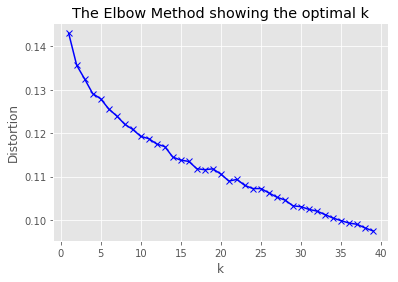

In [179]:
# show results for k ranging from 1 to 39
plt.plot(range(1,max(K)+1), distortions, 'bx-')
plt.xlabel('k')
plt.ylabel('Distortion')
plt.title('The Elbow Method showing the optimal k')
plt.show()

In [45]:
#### Try the method of DBSCAN
# from sklearn.cluster import DBSCAN 
# dbscan = DBSCAN(eps=0.12, min_samples=3).fit(X)
# cluster_labels = dbscan.labels_
# (cluster_labels== 4).sum()

##### 5.3.3.1.2 Use the optimal k for cluster analysis

In [40]:
X = df_freq_by_neighbourhood.iloc[:,3:].values
k_optimal = 4
kmeans = KMeans(n_clusters=k_optimal, n_init=12, random_state=0).fit(X)


##### 5.3.3.1.3 Add the cluster labels to the dataframe

In [41]:
df_complete.insert(0,'Cluster Label',kmeans.labels_)
df_complete.head()

,Cluster Label,City,Borough,Neighbourhood,1st Most Common Category,2nd Most Common Category,3rd Most Common Category,4th Most Common Category,5th Most Common Category,6th Most Common Category,7th Most Common Category,8th Most Common Category,9th Most Common Category,10th Most Common Category,ATM,Accessories Store,Adult Boutique,Afghan Restaurant,African Restaurant,Airport,Airport Lounge,Airport Service,Airport Terminal,American Restaurant,Amphitheater,Animal Shelter,Antique Shop,Aquarium,Arcade,Arepa Restaurant,Argentinian Restaurant,Art Gallery,Art Museum,Arts & Crafts Store,Arts & Entertainment,Asian Restaurant,Athletics & Sports,Auditorium,Australian Restaurant,Austrian Restaurant,Auto Dealership,Auto Garage,Auto Workshop,Automotive Shop,BBQ Joint,Baby Store,Badminton Court,Bagel Shop,Bakery,Bank,Bar,Baseball Field,Baseball Stadium,Basketball Court,Basketball Stadium,Bath House,Beach,Beach Bar,Bed & Breakfast,Beer Bar,Beer Garden,Beer Store,Big Box Store,Bike Rental / Bike Share,Bike Shop,Bike Trail,Bistro,Board Shop,Boarding House,Boat or Ferry,Bookstore,Border Crossing,Botanical Garden,Boutique,Bowling Alley,Boxing Gym,Brazilian Restaurant,Breakfast Spot,Brewery,Bridal Shop,Bridge,Bubble Tea Shop,Buffet,Building,Burger Joint,Burmese Restaurant,Burrito Place,Bus Line,Bus Station,Bus Stop,Business Center,Business Service,Butcher,Cafeteria,Café,Cajun / Creole Restaurant,Cambodian Restaurant,Camera Store,Campground,Candy Store,Cantonese Restaurant,Car Wash,Caribbean Restaurant,Castle,Caucasian Restaurant,Cemetery,Cheese Shop,Chinese Restaurant,Chiropractor,Chocolate Shop,Church,Churrascaria,City Hall,Climbing Gym,Clothing Store,Club House,Cocktail Bar,Coffee Shop,College Academic Building,College Arts Building,College Basketball Court,College Bookstore,College Gym,College Quad,College Rec Center,Colombian Restaurant,Comedy Club,Comfort Food Restaurant,Comic Shop,Community Center,Concert Hall,Construction & Landscaping,Convenience Store,Convention Center,Cooking School,Cosmetics Shop,Costume Shop,Coworking Space,Creperie,Cuban Restaurant,Cultural Center,Cupcake Shop,Curling Ice,Cycle Studio,Czech Restaurant,Dance Studio,Daycare,Deli / Bodega,Department Store,Design Studio,Dessert Shop,Dim Sum Restaurant,Diner,Disc Golf,Discount Store,Distillery,Dive Bar,Doctor's Office,Dog Run,Doner Restaurant,Donut Shop,Dosa Place,Drugstore,Dry Cleaner,Dumpling Restaurant,Dutch Restaurant,Eastern European Restaurant,Egyptian Restaurant,Electronics Store,Elementary School,Empanada Restaurant,English Restaurant,Entertainment Service,Ethiopian Restaurant,Event Service,Event Space,Exhibit,Eye Doctor,Fabric Shop,Factory,Falafel Restaurant,Farm,Farmers Market,Fast Food Restaurant,Field,Filipino Restaurant,Film Studio,Financial or Legal Service,Fish & Chips Shop,Fish Market,Fishing Store,Flea Market,Flower Shop,Food,Food & Drink Shop,Food Court,Food Stand,Food Truck,Football Stadium,Fountain,French Restaurant,Fried Chicken Joint,Frozen Yogurt Shop,Fruit & Vegetable Store,Furniture / Home Store,Gaming Cafe,Garden,Garden Center,Gas Station,Gastropub,Gay Bar,General Entertainment,German Restaurant,Gift Shop,Gluten-free Restaurant,Go Kart Track,Golf Course,Gourmet Shop,Government Building,Greek Restaurant,Grocery Store,Gun Range,Gym,Gym / Fitness Center,Gym Pool,Gymnastics Gym,Hakka Restaurant,Halal Restaurant,Harbor / Marina,Hardware Store,Hawaiian Restaurant,Health & Beauty Service,Health Food Store,Heliport,Herbs & Spices Store,High School,Himalayan Restaurant,Historic Site,History Museum,Hobby Shop,Hockey Arena,Hockey Field,Home Service,Hong Kong Restaurant,Hookah Bar,Hospital,Hostel,Hot Dog Joint,Hotel,Hotel Bar,Hotpot Restaurant,Housing Development,Hungarian Restaurant,IT Services,Ice Cream Shop,Indian Chinese Restaurant,Indian Restaurant,Indie Movie Theater,Indie Theater,Indonesian Restaurant,Indoor Play Area,Insurance Office,Intersection,Irish Pub,Island,Israeli Restaurant,Italian Restaurant,Japanese Restaurant,Jazz Club,Jewelry Store,Jewish Res

In [42]:
df_complete['Cluster Label'].value_counts()
# /df_complete['Cluster Label'].value_counts().sum()

0    205
3    182
1    126
2     57
Name: Cluster Label, dtype: int64

In [ ]:
fig = plt.figure()

#### 5.3.3.2 Given the cluster labels, we summarize the keywords for the clusters

##### 5.3.3.2.1 Install the packages needed for generating word clouds

In [44]:
# install wordcloud
!conda install -c conda-forge wordcloud==1.4.1 --yes

# import package and its set of stopwords
from wordcloud import WordCloud, STOPWORDS

print ('Wordcloud is installed and imported!')

Solving environment: done

## Package Plan ##

  environment location: /opt/conda/envs/Python36

  added / updated specs: 
    - wordcloud==1.4.1


The following packages will be downloaded:

    package                    |            build
    ---------------------------|-----------------
    wordcloud-1.4.1            |           py36_0         324 KB  conda-forge

The following NEW packages will be INSTALLED:

    wordcloud: 1.4.1-py36_0 conda-forge


wordcloud-1.4.1      | 324 KB    | ##################################### | 100% 
Preparing transaction: done
Verifying transaction: done
Executing transaction: done
Wordcloud is installed and imported!


##### 5.3.3.2.2 Generate Word Cloud for each cluster

For each cluster, we first generate the word list. To get the word list, we need to summarize the frequency of each category within each cluster. 

1) Obtain counts by neighbourhood

In [45]:
df_sum_by_neighbourhood = df_onehot.groupby(['City','Borough','Neighbourhood']).sum()
df_sum_by_neighbourhood.insert(0,'Cluster Label', kmeans.labels_)
df_sum_by_neighbourhood.head()

Cluster Label  ATM  Accessories Store  \
City          Borough Neighbourhood                                          
New York City Bronx   Allerton                   3    0                  0   
                      Baychester                 1    0                  1   
                      Bedford Park               3    0                  0   
                      Belmont                    3    0                  0   
                      Bronxdale                  3    0                  0   

                                     Adult Boutique  Afghan Restaurant  \
City          Borough Neighbourhood                                      
New York City Bronx   Allerton                    0                  0   
                      Baychester                  0                  0   
                      Bedford Park                0                  0   
                      Belmont                     0                  0   
                      Bronxdale                   0                  0   

                                     African Restaurant  Airport  \
City          Borough Neighbourhood                                
New York City Bronx   Allerton                        0        0   
                      Baychester                      0        0   
                      Bedford Park                    0        0   
                      Belmont                         1        0   
                      Bronxdale                       0        0   

                                     Airport Lounge  Airport Service  \
City          Borough Neighbourhood                                    
New York City Bronx   Allerton                    0                0   
                      Baychester                  0                0   
                      Bedford Park                0                0   
                      Belmont                     0                0   
                      Bronxdale                   0                0   

                                     Airport Terminal  American Restaurant  \
City          Borough Neighbourhood                                          
New York City Bronx   Allerton                      0                    0   
                      Baychester                    0                    0   
                      Bedford Park                  0                    0   
                      Belmont                       0                    0   
                      Bronxdale                     0                    0   

                                     Amphitheater  Animal Shelter  \
City          Borough Neighbourhood                                 
New York City Bronx   Allerton                  0               0   
                      Baychester                0               0   
                      Bedford Park              0               0   
                      Belmont                   0               0   
                      Bronxdale                 0               0   

                                     Antique Shop  Aquarium  Arcade  \
City          Borough Neighbourhood                                   
New York City Bronx   Allerton                  0         0       0   
                      Baychester                0         0       0   
                      Bedford Park              0         0       0   
                      Belmont                   0         0       0   
                      Bronxdale                 0         0       0   

                                     Arepa Restaurant  Argentinian Restaurant  \
City          Borough Neighbourhood                                             
New York City Bronx   Allerton                      1                       0   
                      Baychester                    0                       0   
                      Bedford Park                  0                       0   
                      Belmont                       0  

2) Obtain counts by cluster

In [46]:
df_sum_by_cluster = df_sum_by_neighbourhood.groupby('Cluster Label').sum().astype('int32')
df_sum_by_cluster

,ATM,Accessories Store,Adult Boutique,Afghan Restaurant,African Restaurant,Airport,Airport Lounge,Airport Service,Airport Terminal,American Restaurant,Amphitheater,Animal Shelter,Antique Shop,Aquarium,Arcade,Arepa Restaurant,Argentinian Restaurant,Art Gallery,Art Museum,Arts & Crafts Store,Arts & Entertainment,Asian Restaurant,Athletics & Sports,Auditorium,Australian Restaurant,Austrian Restaurant,Auto Dealership,Auto Garage,Auto Workshop,Automotive Shop,BBQ Joint,Baby Store,Badminton Court,Bagel Shop,Bakery,Bank,Bar,Baseball Field,Baseball Stadium,Basketball Court,Basketball Stadium,Bath House,Beach,Beach Bar,Bed & Breakfast,Beer Bar,Beer Garden,Beer Store,Big Box Store,Bike Rental / Bike Share,Bike Shop,Bike Trail,Bistro,Board Shop,Boarding House,Boat or Ferry,Bookstore,Border Crossing,Botanical Garden,Boutique,Bowling Alley,Boxing Gym,Brazilian Restaurant,Breakfast Spot,Brewery,Bridal Shop,Bridge,Bubble Tea Shop,Buffet,Building,Burger Joint,Burmese Restaurant,Burrito Place,Bus Line,Bus Station,Bus Stop,Business Center,Business Service,Butcher,Cafeteria,Café,Cajun / Creole Restaurant,Cambodian Restaurant,Camera Store,Campground,Candy Store,Cantonese Restaurant,Car Wash,Caribbean Restaurant,Castle,Caucasian Restaurant,Cemetery,Cheese Shop,Chinese Restaurant,Chiropractor,Chocolate Shop,Church,Churrascaria,City Hall,Climbing Gym,Clothing Store,Club House,Cocktail Bar,Coffee Shop,College Academic Building,College Arts Building,College Basketball Court,College Bookstore,College Gym,College Quad,College Rec Center,Colombian Restaurant,Comedy Club,Comfort Food Restaurant,Comic Shop,Community Center,Concert Hall,Construction & Landscaping,Convenience Store,Convention Center,Cooking School,Cosmetics Shop,Costume Shop,Coworking Space,Creperie,Cuban Restaurant,Cultural Center,Cupcake Shop,Curling Ice,Cycle Studio,Czech Restaurant,Dance Studio,Daycare,Deli / Bodega,Department Store,Design Studio,Dessert Shop,Dim Sum Restaurant,Diner,Disc Golf,Discount Store,Distillery,Dive Bar,Doctor's Office,Dog Run,Doner Restaurant,Donut Shop,Dosa Place,Drugstore,Dry Cleaner,Dumpling Restaurant,Dutch Restaurant,Eastern European Restaurant,Egyptian Restaurant,Electronics Store,Elementary School,Empanada Restaurant,English Restaurant,Entertainment Service,Ethiopian Restaurant,Event Service,Event Space,Exhibit,Eye Doctor,Fabric Shop,Factory,Falafel Restaurant,Farm,Farmers Market,Fast Food Restaurant,Field,Filipino Restaurant,Film Studio,Financial or Legal Service,Fish & Chips Shop,Fish Market,Fishing Store,Flea Market,Flower Shop,Food,Food & Drink Shop,Food Court,Food Stand,Food Truck,Football Stadium,Fountain,French Restaurant,Fried Chicken Joint,Frozen Yogurt Shop,Fruit & Vegetable Store,Furniture / Home Store,Gaming Cafe,Garden,Garden Center,Gas Station,Gastropub,Gay Bar,General Entertainment,German Restaurant,Gift Shop,Gluten-free Restaurant,Go Kart Track,Golf Course,Gourmet Shop,Government Building,Greek Restaurant,Grocery Store,Gun Range,Gym,Gym / Fitness Center,Gym Pool,Gymnastics Gym,Hakka Restaurant,Halal Restaurant,Harbor / Marina,Hardware Store,Hawaiian Restaurant,Health & Beauty Service,Health Food Store,Heliport,Herbs & Spices Store,High School,Himalayan Restaurant,Historic Site,History Museum,Hobby Shop,Hockey Arena,Hockey Field,Home Service,Hong Kong Restaurant,Hookah Bar,Hospital,Hostel,Hot Dog Joint,Hotel,Hotel Bar,Hotpot Restaurant,Housing Development,Hungarian Restaurant,IT Services,Ice Cream Shop,Indian Chinese Restaurant,Indian Restaurant,Indie Movie Theater,Indie Theater,Indonesian Restaurant,Indoor Play Area,Insurance Office,Intersection,Irish Pub,Island,Israeli Restaurant,Italian Restaurant,Japanese Restaurant,Jazz Club,Jewelry Store,Jewish Restaurant,Juice Bar,Karaoke Bar,Kebab Restaurant,Kids Store,Kitchen Supply Store,Kofte Place,Korean Restaurant,Kosher Restaurant,Lake,Laser Tag,Latin American Restaurant,Laundromat,Laundry Service,Lawyer,Leather Goods Store,Lebanese Restaurant,Library,Light Rail Station,Lighthouse,Lighting Sto

3) Generate a list of words for each cluster

In [47]:
Max = 100
def WordListGenerator(Values):
    WordList = ''
    for index in Values.index.values:
        if len(index.split()) > 1:
            key_word = ''.join(index.split())
        else:
            key_word = index
        repeat_times = int(Values[index]/sum(Values)*Max)
        WordList = WordList + (key_word+ ' ') * repeat_times
    
    return WordList
        
     

4) Generate a word cloud based on the wordlist

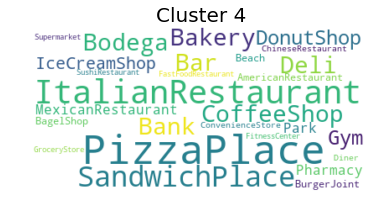

In [48]:
stopwords = set(STOPWORDS)

# instantiate a word cloud object
cluster_words = WordCloud(
    background_color='white',
    max_words=1000,
    stopwords=stopwords
)

# generate the word cloud
cluster_words.generate(WordListGenerator(df_sum_by_cluster.iloc[3,:]))

# display the word cloud
plt.imshow(cluster_words, interpolation='bilinear')
plt.axis('off')
plt.title('Cluster 4', fontsize=20)
plt.show()

#### 5.3.3.3 Compute similarity across different clusters

1) Obtain the centroid of each cluster

In [50]:
import pandas as pd
from scipy.spatial import distance_matrix

centroids = kmeans.cluster_centers_
centroids_data = pd.DataFrame(centroids,columns=df_sum_by_cluster.columns,index=df_sum_by_cluster.index)

pd.DataFrame(distance_matrix(centroids_data.values, centroids_data.values), columns=['Cluster 1','Cluster 2','Cluster 3','Cluster 4'], index = ['Cluster 1','Cluster 2','Cluster 3','Cluster 4'])
# data = [[5, 7], [7, 3], [8, 1]]
# ctys = ['Boston', 'Phoenix', 'New York']
# df = pd.DataFrame(data, columns=['xcord', 'ycord'], index=ctys)
# pd.DataFrame(distance_matrix(df.values, df.values), index=df.index, columns=df.index)

,Cluster 1,Cluster 2,Cluster 3,Cluster 4
Cluster 1,0.000000,0.125759,0.113263,0.082982
Cluster 2,0.125759,0.000000,0.126532,0.084382
Cluster 3,0.113263,0.126532,0.000000,0.117618
Cluster 4,0.082982,0.084382,0.117618,0.000000


In [256]:
centroids_data.values

array([[ 1.04922913e-03,  3.38813179e-20, -4.60785923e-19, ...,
         6.49430749e-04,  2.38524478e-18,  5.20417043e-18],
       [ 1.34228188e-04,  2.71050543e-20,  2.68456376e-04, ...,
         3.07211866e-03,  3.69828183e-03,  1.67785235e-03],
       [ 2.42786770e-03,  2.71050543e-20,  8.13151629e-20, ...,
         1.72413793e-03,  3.44827586e-04,  3.44827586e-04],
       [ 5.17241379e-04,  3.38813179e-20,  1.11453202e-03, ...,
         1.76416256e-03,  0.00000000e+00,  4.31034483e-04],
       [ 1.61281652e-04,  1.43540670e-04, -9.21571847e-19, ...,
         1.17840778e-02,  8.80641407e-04,  5.01616449e-03]])

#### 5.3.3.4 Distribution of Clusters for Each City

1) Obtain the portion of the data attached with a certain city

In [43]:
list_of_cities = ['New York City','Philadelphia','Toronto']
distribution_of_clusters = pd.DataFrame(columns=['Cluster 1', 'Cluster 2', 'Cluster 3', 'Cluster 4'])
for item in list_of_cities:
    df_city = df_complete[df_complete['City']==item]
    distribution_of_clusters = distribution_of_clusters.append({'Cluster 1': sum(df_city['Cluster Label']==0),
                                    'Cluster 2': sum(df_city['Cluster Label']==1),
                                    'Cluster 3': sum(df_city['Cluster Label']==2),
                                    'Cluster 4': sum(df_city['Cluster Label']==3)},ignore_index=True)
distribution_of_clusters.index=list_of_cities
distribution_of_clusters['Total'] = distribution_of_clusters.sum(axis=1)
distribution_of_clusters.iloc[:,:4] = distribution_of_clusters.iloc[:,:4].div(distribution_of_clusters['Total'],axis=0)
distribution_of_clusters = distribution_of_clusters.astype(float).round(2)
distribution_of_clusters

,Cluster 1,Cluster 2,Cluster 3,Cluster 4,Total
New York City,0.34,0.16,0.01,0.49,306.0
Philadelphia,0.34,0.47,0.00,0.19,161.0
Toronto,0.46,0.00,0.53,0.01,103.0


2) Plot histogram (barplot) for each city

Text(0.5, 1.0, 'Toronto')

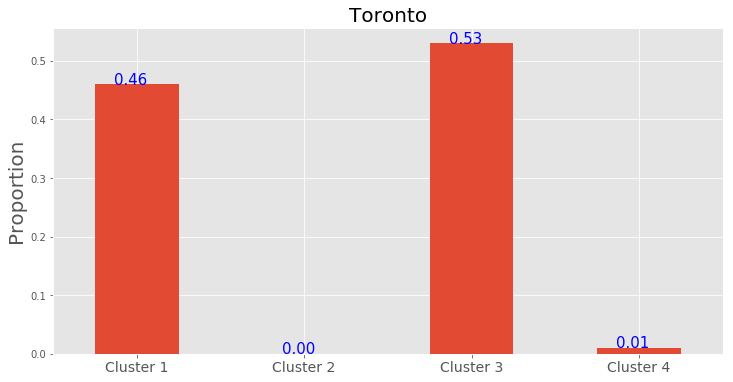

In [44]:
# data_for_hist = df_complete[df_complete['City']=='Philadelphia']['Cluster Label']
# d = np.diff(np.unique(data_for_hist)).min()
# left_of_first_bin = data_for_hist.min() - float(d)/2
# right_of_last_bin = data_for_hist.max() + float(d)/2
# fig = plt.figure(figsize=(12,6))
# ax= plt.hist(data_for_hist, np.arange(left_of_first_bin, right_of_last_bin + d, d), edgecolor='k')
df_barplot = distribution_of_clusters.iloc[2,0:4]
ax = df_barplot.plot(kind='bar',figsize=(12,6))
plt.ylabel('Proportion',fontsize=20)
ax.set_xticklabels( ['Cluster 1', 'Cluster 2', 'Cluster 3', 'Cluster 4'] )
for tick in ax.xaxis.get_major_ticks():
                tick.label.set_fontsize(14) 
                # specify integer or one of preset strings, e.g.
                #tick.label.set_fontsize('x-small') 
                tick.label.set_rotation('horizontal')
for index, value in enumerate(df_barplot):
    label = "{:.2f}".format(value) 
    plt.annotate(label,
                xy = (index-0.135,value),
                color = 'blue',fontsize=15)
plt.title('Toronto',fontsize=20)

3) Similarity across three cities.

In [61]:
distribution_of_clusters_by_city = distribution_of_clusters[['Cluster 1', 'Cluster 2', 'Cluster 3', 'Cluster 4']]
pd.DataFrame(distance_matrix(distribution_of_clusters_by_city.values, distribution_of_clusters_by_city.values), 
             columns=['New York City','Philadelphia','Toronto'], index = ['New York City','Philadelphia','Toronto'])

,New York City,Philadelphia,Toronto
New York City,0.000000,0.431509,0.735391
Philadelphia,0.431509,0.000000,0.740675
Toronto,0.735391,0.740675,0.000000
